# Paired Tumor/Normal microarray survey from GEO

Here I'm profiling tumor/normal datasets found in GEO. This is a processing/QC runthrough where I'm going to parse and map all of the different microarray formats to gene symbols and take a quick look at whether this is a good dataset for comparison with the TCGA data. 

The QC stuff is not really necessary for importing so I'm going to go ahead and dump all of these clean matched datasets into a HDF store. I'm going to use the TCGA convention of '01' meaning tumor and '11' meaning normal.  For subject ID's I'll use the ID's supplied unless I get overlaps. 

In [1]:
import NotebookImport
from DX_screen import *

importing IPython notebook from DX_screen

importing IPython notebook from Imports

importing IPython notebook from /cellar/users/agross/anaconda2/lib/python2.7/site-packages/MethylTools/Probe_Annotations

Using a flat data storage structure, basically just relying on GEO id's to differentiate files.

In [2]:
PATH =  '/cellar/users/agross/Data/DiffExp/Data/'
DATA = {}

#### Data Summary 
* I'm using the TCGA refrence fraction hard coded into here. I'll do more complex analysis in other places. 
* I like to keep this global as we can easily tweak and add metrics to our analysis.

In [80]:
from IPython.display import display_html

REFERENCE_FRAC = dx_rna.frac
REFERENCE_FRAC.name = 'TCGA Reference'
def data_summary(df, tissue=None):    
    rr = binomial_test_screen(df, fc=1.)
    rr.name = 'Dataset F_g'
    
    print 'Top hits:'
    display_html(rr.sort('p').head())
    
    if tissue is None:
        fig, axs = subplots(1,2, figsize=(9,4))
    else:
        fig, axs = subplots(1,3, figsize=(13,4))
    rr.frac.hist(bins=20, ax=axs[0])
    axs[0].set_ylabel('Number of Genes')
    axs[0].set_xlabel('F_g')
    prettify_ax(axs[0])
    
    s1, s2 = match_series(REFERENCE_FRAC, rr.frac)
    print '{} matching genes in dataset.'.format(len(s1))
    plot_regression(s1, s2, density=True, rad=.1, ax=axs[1])
    axs[1].set_ylabel('F_g')
    
    if tissue is not None:
        tcga = binomial_test_screen(matched_tn.ix[:, ti(codes == tissue)], fc=1.)
        s1, s2 = match_series(tcga.frac, rr.frac)
        s1.name = 'TCGA {}'.format(tissue)
        s2.name = 'F_g'
        plot_regression(s1, s2, density=True, rad=.1, ax=axs[2])
    fig.tight_layout()

#Breast Cancer
[GSE39004](http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE39004)

Molecular Profiles of Human Breast Cancer and Their Association with Tumor Subtypes and Disease Prognosis

In [81]:
f = PATH + 'GSE39004-GPL6244_series_matrix.txt'
meta = pd.read_table(f, skiprows=28, nrows=43, index_col=0,
                     low_memory=False)
df = pd.read_table(f, skiprows=74, index_col=0, names=meta.columns).dropna()
cols = [(c.split()[1], '11' if c.split()[0].startswith('Normal') else '01') 
        for c in df.columns]
df.columns = pd.MultiIndex.from_tuples(cols)
df = df.sort_index(axis=1)

In [47]:
rr = binomial_test_screen(df, 1.)

In [48]:
rr.sort('p').head()

,num_ox,num_dx,frac,p
8161488,0,45,0,5.68e-14
8161558,0,45,0,5.68e-14
8155442,0,45,0,5.68e-14
8176193,0,45,0,5.68e-14
8155554,0,45,0,5.68e-14


In [82]:
f = PATH + 'GPL6244-24073.txt'
mapping = pd.read_table(f, skiprows=12, index_col='ID', )

In [83]:
hugo_refseq = pd.read_csv('/cellar/users/agross/Data/GeneSets/hugo_to_refseq.csv').dropna()
hugo_refseq = hugo_refseq.set_index('RefSeq (mapped data supplied by NCBI)')['Approved Symbol']
to_gene = pd.Series({i: hugo_refseq[s] for i,v in mapping.GB_LIST.dropna().iteritems()
                    for s in v.split(',') if s in hugo_refseq.index})

In [84]:
d2 = df.groupby(to_gene).mean()

Top hits:


,num_ox,num_dx,frac,p
F8,0,45,0,5.68e-14
PARK2,0,45,0,5.68e-14
HEPN1,0,45,0,5.68e-14
TNS2,0,45,0,5.68e-14
GPAM,0,45,0,5.68e-14


13825 matching genes in dataset.


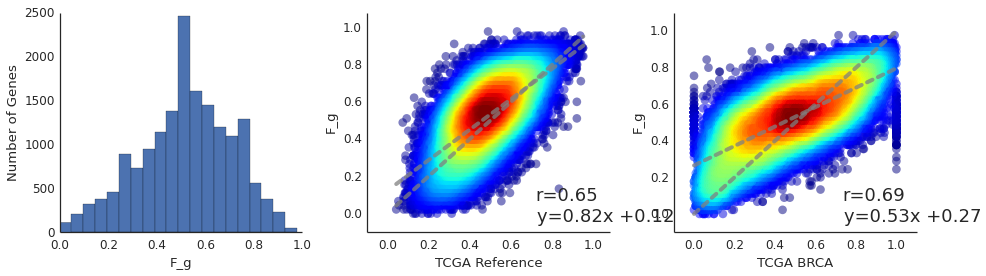

In [85]:
data_summary(d2, 'BRCA')

In [86]:
DATA[('BRCA','GSE39004')] = d2

#Colon Cancer

[GSE68468](http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE68468)

RNA expression data was generated as part of a colon cancer study. Samples were obtained from patients, including primary colon cancer, polyps, metastases, and matched normal mucosa (obtained from the margins of the resection). The RNA was extracted from tissue samples obtained from resections and hybridized to Affymetrix HG-U133 arrays. RNA expression data was also obtained for a few cell lines.


In [87]:
f = PATH + 'GSE68468_series_matrix.txt'
meta = pd.read_table(f, skiprows=39, nrows=35, index_col=0)
df = pd.read_table(f, skiprows=77, index_col=0, names=meta.columns)
cols = [(m.ix[6], m.ix[12].split(': ')[1]) for i,m in meta.iteritems()]
df.columns = pd.MultiIndex.from_tuples(cols)
df = df.groupby(axis=1,level=[0,1]).first()
c2 = [c for c in cols if (c[0],'colon cancer') in cols 
        and (c[0], 'normal colon mucosa') in cols
        and c[1] in ['colon cancer','normal colon mucosa']]
df = df[c2]
df = np.log2(df)
c3 = [(c[0], '11' if 'normal' in c[1] else '01') for c in c2]
df.columns = pd.MultiIndex.from_tuples(c3)

In [88]:
f = PATH + 'GPL96-15653.txt'
mapping = pd.read_table(f, skiprows=16, index_col='ID', usecols=['ID','Gene Symbol'],
                        squeeze=True).dropna()
d2 = df.groupby(mapping).mean()

Top hits:


,num_ox,num_dx,frac,p
Gene Symbol,,,,
FUCA1,0,46,0,2.84e-14
NR3C2,0,46,0,2.84e-14
GUCA2A,0,46,0,2.84e-14
ATP11A,46,46,1,2.84e-14
PDE9A,0,46,0,2.84e-14


12017 matching genes in dataset.


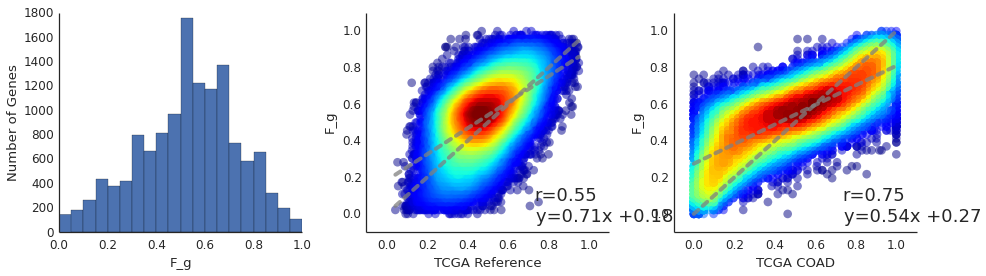

In [91]:
data_summary(d2, 'COAD')

In [92]:
DATA[('COAD','GSE68468')] = d2

# Kidney Cancer 

[GSE53757](http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE53757)

In order to identify novel tumor-specific targets, we performed high throughput gene array analysis screening numerous patient ccRCC tumor tissues across all stages of disease, and compared their gene expression levels to matched normal kidney. Our results identify a number of genes which demonstrate tumor-specific overexpression, and may present as novel targets for therapy.

In [93]:
f = PATH + 'GSE53757_series_matrix.txt'
meta = pd.read_table(f, skiprows=29, nrows=30, index_col=0)
df = pd.read_table(f, skiprows=63, index_col=0, names=meta.columns)
cols = [(c[:-1], '11' if c.endswith('N') else '01') 
        for c in df.columns]
df.columns = pd.MultiIndex.from_tuples(cols)
df = df.dropna()

In [94]:
f = PATH + 'GPL570-13270.txt'
mapping = pd.read_table(f, skiprows=16, index_col='ID', usecols=['ID','Gene Symbol'],
                        squeeze=True).dropna()
d2 = df.groupby(mapping).mean()
#c2 = list(d2.columns[2:]) + [d2.columns[0], d2.columns[1]]
#idx = pd.MultiIndex.from_tuples([(i/2, j[1]) for i,j in enumerate(c2)])
idx = pd.MultiIndex.from_tuples([(str(i/2), str(j[1])) for i,j in enumerate(d2.columns)])
d2.columns = idx

Top hits:


,num_ox,num_dx,frac,p
Gene Symbol,,,,
HK2,71,72,0.99,3.09e-20
GGT6,1,72,0.01,3.09e-20
CHST15,71,72,0.99,3.09e-20
LAMA4,71,72,0.99,3.09e-20
CHPF2,71,72,0.99,3.09e-20


17164 matching genes in dataset.


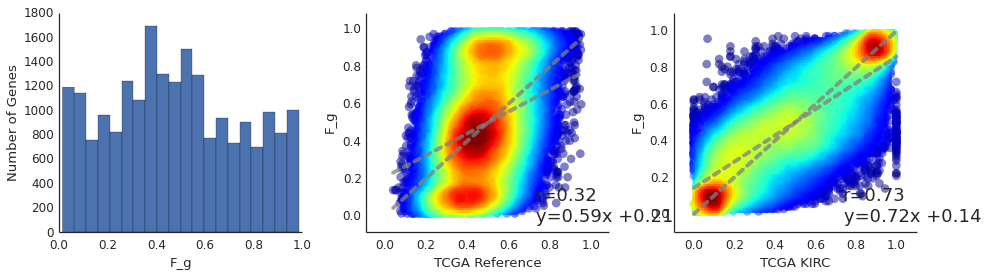

In [95]:
data_summary(d2, 'KIRC')

In [96]:
DATA[('KIRC','GSE53757')] = d2

# Prostate Cancer

[GSE62872](http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE62872)

264 prostate tumor and 160 normal prostate tissue samples from the Health Professionals Follow-up Study and Physicians' Health Study Prostate Tumor Cohort. We tested the association of 39 prostate cancer risk variants with Affymetrix gene expression array data. We compared each variant to all nearby genes (500 kb up- and downstream), as well as with all genes and KEGG pathways.

In [97]:
f = PATH + 'GSE62872_series_matrix.txt'
meta = pd.read_table(f, nrows=68, skiprows=27, index_col=0)
df = pd.read_table(f, skiprows=96, index_col=0, names=meta.columns)
cols = [(c.split('_')[2], '11' if c.startswith('Normal') else '01') 
        for c in df.columns]
df.columns = pd.MultiIndex.from_tuples(cols)
df = df.dropna()

Top hits:


,num_ox,num_dx,frac,p
SLC14A1,17,160,0.11,5.33e-26
ARHGEF38,142,160,0.89,4.27e-25
MEIS2,18,160,0.11,4.27e-25
TRIM29,19,160,0.12,3.22e-24
SNORA71A,140,160,0.88,2.29e-23


17375 matching genes in dataset.


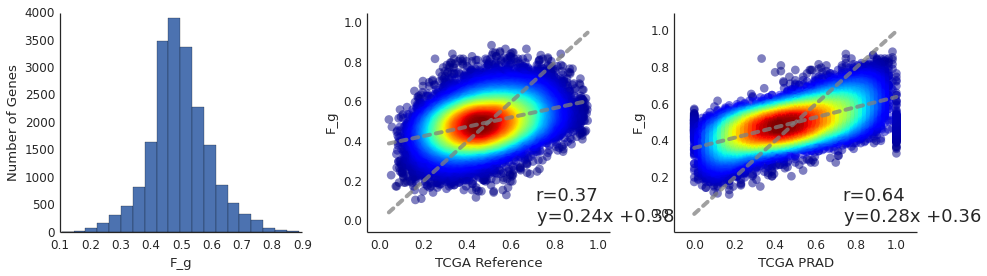

In [98]:
data_summary(df, 'PRAD')

In [99]:
DATA[('PRAD', 'GSE62872')] = df

# hepatocellular carcinoma

[GSE39791](http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE39791)  

"We generated gene expression data from tumor and matched non-tumor surrounding tissues of 72 HCC patients who underwent surgical resection as the primary treatment."

In [100]:
f = PATH + 'GSE39791_series_matrix.txt'
meta = pd.read_table(f, nrows=36, skiprows=30, index_col=0)
df = pd.read_table(f, skiprows=67, index_col=0, header=None)
df = df.dropna()
cols = [(c[:-1], '11' if c[-1] == 'N' else '01') 
        for c in meta.columns]
df.columns = pd.MultiIndex.from_tuples(cols)

In [101]:
f = PATH + 'GPL10558-11219.txt'
mapping = pd.read_table(f, skiprows=30, index_col='ID', usecols=['ID','Symbol'],
                        squeeze=True)
d2 = df.groupby(mapping).mean()

Top hits:


,num_ox,num_dx,frac,p
Symbol,,,,
LARS,70,72,0.97,1.11e-18
NAT2,2,72,0.03,1.11e-18
FCN2,2,72,0.03,1.11e-18
IGFBP3,2,72,0.03,1.11e-18
IGFALS,2,72,0.03,1.11e-18


17758 matching genes in dataset.


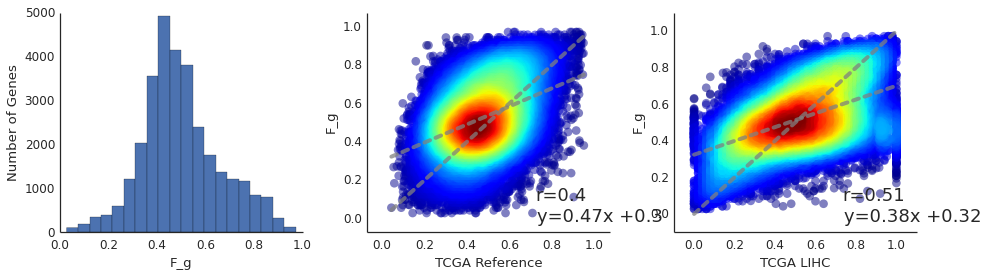

In [102]:
data_summary(d2, 'LIHC')

In [103]:
DATA[('LIHC', 'GSE39791')] = d2

# Non-small cell lung cancer

* [GSE33532](http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE33532)
* 3 Tumor biopsies + normal sample 
* Four different sites (A,B,C,D) of individual primary tumors and matched distant normal lung tissue (N) from 20 patients were used to establish gene expression patterns captured by Affymetrix HG-U133 Plus 2.0 arrays (n = 100).

In [104]:
f = PATH + 'GSE33532_series_matrix.txt'

meta = pd.read_table(f, nrows=34, skiprows=37, index_col=0)
df = pd.read_table(f, skiprows=73, index_col=0, names=meta.columns)
cols = [(c.split(',')[0], '11' if 'normal' in c else '01', 
         'N' if 'normal' in c else c[-1]) 
        for c in df.columns]
df.columns = pd.MultiIndex.from_tuples(cols)
df = df.dropna()

In [105]:
f = PATH + 'GPL570-13270.txt'
mapping = pd.read_table(f, skiprows=16, index_col='ID', usecols=['ID','Gene Symbol'],
                        squeeze=True).dropna()
d2 = df.groupby(mapping).mean()

Have to do some post-processing here due to weird study design. I'm not sure the best way to do this, but for now I'll just average the three tumor replicates.  We are very clearly loosing power but don't want to increase complexity too much. 

I could also use the same normal sample for all three tumor samples, boosting the sample size, but this could be considered an un-Kosher way of boosting power.

In [106]:
tumor = (d2.xs('A', axis=1, level=2) + 
         d2.xs('B', axis=1, level=2) + 
         d2.xs('C', axis=1, level=2)) / 3.
normal = d2.xs('N', axis=1, level=2)
d3 = tumor.join(normal)

Top hits:


,num_ox,num_dx,frac,p
Gene Symbol,,,,
TMEM173,0,20,0,1.91e-06
C1orf61,20,20,1,1.91e-06
KRT33A,20,20,1,1.91e-06
KRT4,0,20,0,1.91e-06
KRT6A /// KRT6B /// KRT6C,20,20,1,1.91e-06


13745 matching genes in dataset.


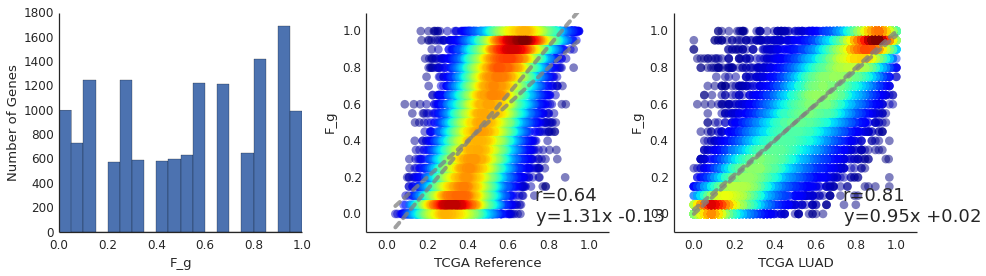

In [107]:
data_summary(d3, 'LUAD')

In [108]:
DATA[('NSCLC','GSE33532')] = d3

# Liver 

[GSE25097](http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE25097) 

Huge Merck study. 

"Hepatocellular carcinoma (HCC) affects millions of people worldwide and is a lethal malignancy for which there are no effective therapies. To identify prognostic gene markers for liver cancer, we conducted transcriptome profiling of frozen tissues (tumor and non-tumor) from 300 early-to-advanced stage HCCs plus 40 cirrhotic and 6 normal livers."

In [109]:
f = PATH + 'GSE25097_series_matrix.txt'
meta = pd.read_table(f, nrows=29, skiprows=26, index_col=0)
df = pd.read_table(f, skiprows=56, index_col=0, names=meta.columns)
df = df.dropna()
tissue = meta.iloc[6].replace({'tumor':'01', 'non_tumor':'11'})
cols = [(i.split()[-1],v) for i,v in tissue.iteritems()]
df.columns = pd.MultiIndex.from_tuples(cols)
df = df.sort_index(axis=1)

In [110]:
f = PATH + 'GPL10687.txt'
mapping = pd.read_table(f, skiprows=7, index_col='ID', usecols=['ID','GeneSymbol'],
                        squeeze=True).dropna()
d2 = df.groupby(mapping).mean()

Top hits:


,num_ox,num_dx,frac,p
GeneSymbol,,,,
FCN2,0,243,0,1.41e-73
MARCO,0,243,0,1.41e-73
GPM6A,0,243,0,1.41e-73
ECM1,0,243,0,1.41e-73
CCNB1,243,243,1,1.41e-73


16289 matching genes in dataset.


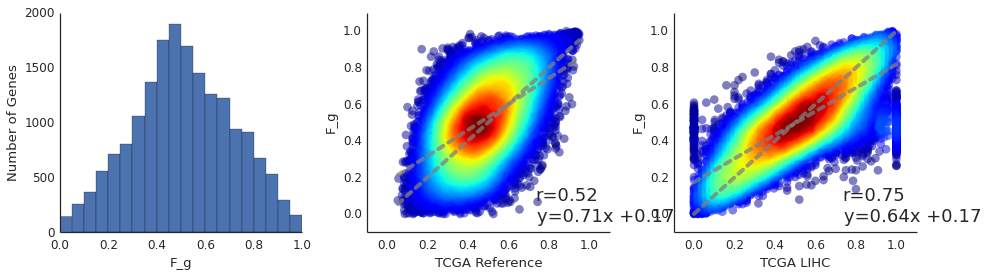

In [111]:
data_summary(d2, 'LIHC')

In [112]:
DATA[('LIHC','GSE25097')] = d2

# Liver Cancer

* [GSE14520](http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE14520) 
* " We used Affymetrix microarray profiling to analyze gene expression patterns in healthy donor liver as well as tumor and paired non-tumor tissue of HCC patients."
* Also has clinical followup 
* Has a secondary array, I think I'll lump them together for now

In [113]:
f = PATH + 'GSE14520-GPL3921_series_matrix.txt'
meta = pd.read_table(f, nrows=37, skiprows=37, index_col=0)
df = pd.read_table(f, skiprows=79, index_col=0, names=meta.columns)
df = df.dropna()
tissue = meta.iloc[8].map(lambda s: s.split(': ')[1])
tissue = tissue.replace({'Liver Tumor Tissue':'01', 'Liver Non-Tumor Tissue':'11'})
patient = meta.iloc[10].map(lambda s: s.split(': ')[1][:-1])
cols = [(patient[i], tissue[i]) for i in tissue.index]
df.columns = pd.MultiIndex.from_tuples(cols)
df = df.sort_index(axis=1)

In [114]:
f = PATH + 'GPL3921-25447.txt'
mapping = pd.read_table(f, skiprows=16, index_col='ID', usecols=['ID','Gene Symbol'],
                        squeeze=True).dropna()
d2 = df.groupby(mapping).mean()

Top hits:


,num_ox,num_dx,frac,p
Gene Symbol,,,,
SNRPE,212,213,1.00,3.25e-62
PSMB4,212,213,1.00,3.25e-62
ECM1,1,213,0.00,3.25e-62
LCAT,1,213,0.00,3.25e-62
CCNB1,211,213,0.99,3.46e-60


10967 matching genes in dataset.


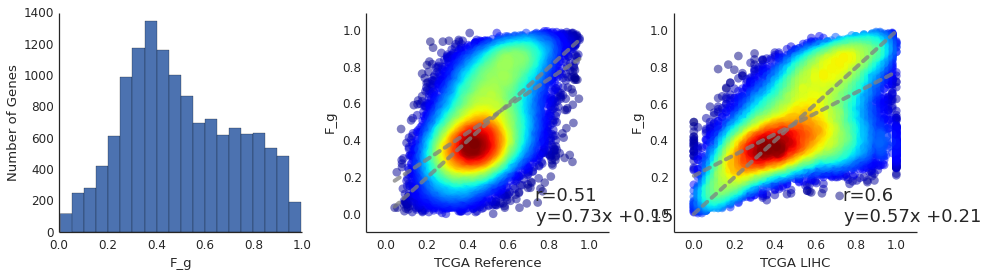

In [115]:
data_summary(d2, 'LIHC')

In [116]:
DATA[('LIHC','GSE14520')] = d2

# Colon

* [GSE44076](http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE44076)
* Has 50 healthy samples, I'm going to toss them for now 
* http://www.colonomics.org 
* All stage II without adjuvent therepy 
* No MSI tumors 
* Also have miRNA and methylation

Gene expression profiles of paired normal adjacent mucosa and tumor samples from 98 individuals and 50 healthy colon mucosae, were obtained through Affymetrix Human Genome U219 Arrays.

In [117]:
f = PATH + 'GSE44076_series_matrix.txt'
meta = pd.read_table(f, nrows=36, skiprows=41, index_col=0, low_memory=False)
df = pd.read_table(f, skiprows=79, index_col=0, names=meta.columns)

In [118]:
tissue = meta.iloc[6].replace({'Normal distant colon mucosa cells': '11',
                               'Primary colon adenocarcinoma cells': '01',
                               'Healthy colon mucosa cells': 'N'})
patient = meta.iloc[9].map(lambda s: s.split()[-1])
cols = [(patient[i], tissue[i]) for i in tissue.index]
df.columns = pd.MultiIndex.from_tuples(cols)
df = df.sort_index(axis=1).dropna()

In [119]:
f = PATH + 'GPL13667-15572.txt'
mapping = pd.read_table(f, skiprows=43, index_col='ID', usecols=['ID','Gene Symbol'],
                        squeeze=True).dropna()
d2 = df.groupby(mapping).mean()

Top hits:


,num_ox,num_dx,frac,p
Gene Symbol,,,,
C12orf11,98,98,1,6.31e-30
TTYH3,98,98,1,6.31e-30
NAT9,98,98,1,6.31e-30
LMBR1,98,98,1,6.31e-30
ZNF611,0,98,0,6.31e-30


17225 matching genes in dataset.


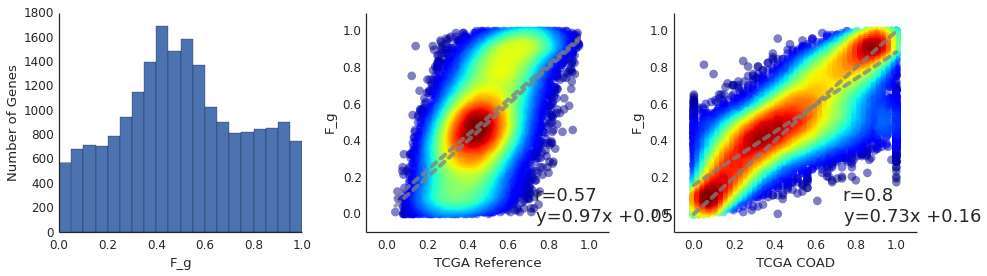

In [120]:
data_summary(d2, 'COAD')

In [121]:
DATA[('COAD','GSE44076')] = d2

# Grab bag study

* [GSE5364](http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE5364) 
* Handfull of different tissues 

The training set used in this study comprises 341 samples (270 tumors and 71 matched normals) from patients with breast, colon, liver, lung, oesophagal and thyroid cancer (Tissue Type/Tumor/Normal : Lung/18/12, Thyroid/35/16, Liver/9/8, Oesophagus/16/13, Colon/9/9, Breast/183/13.) 

In [122]:
f = PATH + 'GSE5364_series_matrix.txt'
meta = pd.read_table(f, nrows=32, skiprows=26, index_col=0, low_memory=False)
df = pd.read_table(f, skiprows=60, index_col=0, names=meta.columns)

cols = [(c.split()[0] + '_' + c.split()[-1], '11' if 'normal' in c.lower() else '01') 
        for c in df.columns]
df.columns = pd.MultiIndex.from_tuples(cols)
df = df.dropna()
df = df.sort_index(axis=1)

In [123]:
f = PATH + 'GPL96-15653.txt'
mapping = pd.read_table(f, skiprows=16, index_col='ID', usecols=['ID','Gene Symbol'],
                        squeeze=True).dropna()
d2 = df.groupby(mapping).mean()

Top hits:


,num_ox,num_dx,frac,p
Gene Symbol,,,,
ADH1B,2,71,0.03,2.17e-18
TNXA /// TNXB,4,71,0.06,8.74e-16
RPN2,66,71,0.93,1.19e-14
SRPX,6,71,0.08,1.33e-13
ITM2A,6,71,0.08,1.33e-13


12017 matching genes in dataset.


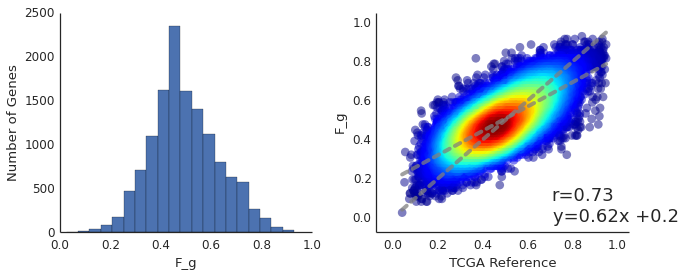

In [124]:
data_summary(d2)

In [125]:
DATA[('PANCAN','GSE5364')] = d2

# Colorectal Cancers and Metastases

'06' is TCGA lingo for metastases.

In [126]:
f = PATH + 'GSE41258_series_matrix.txt'
meta = pd.read_table(f, nrows=45, skiprows=33, index_col=0, low_memory=False)
df = pd.read_table(f, skiprows=80, index_col=0, names=meta.columns)

In [127]:
patient = meta.iloc[10].map(lambda s: s.split()[-1])
def tissue_fx(s):
    if 'Tumor' in s:
        return '01'
    if 'Normal' in s:
        return '11'
    if 'Metastasis' in s:
        return '06'
    else:
        return s.split(': ')[-1]
tissue = meta.iloc[8].map(tissue_fx)

cols = [(patient[i], tissue[i]) for i in tissue.index]
df.columns = pd.MultiIndex.from_tuples(cols)
df = df.sort_index(axis=1).dropna()

In [128]:
f = PATH + 'GPL96-15653.txt'
mapping = pd.read_table(f, skiprows=16, index_col='ID', usecols=['ID','Gene Symbol'],
                        squeeze=True).dropna()
d2 = df.groupby(mapping).mean()

We have a few differnt tissues represented here.

In [129]:
tissue.value_counts().head()

01              186
11               74
06               67
Polyp            48
Microadenoma      2
dtype: int64

#### Tumor vs. Normal

Top hits:


,num_ox,num_dx,frac,p
Gene Symbol,,,,
TMEM100,0,53,0,2.22e-16
GTF3A,53,53,1,2.22e-16
SSB,53,53,1,2.22e-16
CLEC3B,0,53,0,2.22e-16
HEATR1,53,53,1,2.22e-16


12017 matching genes in dataset.


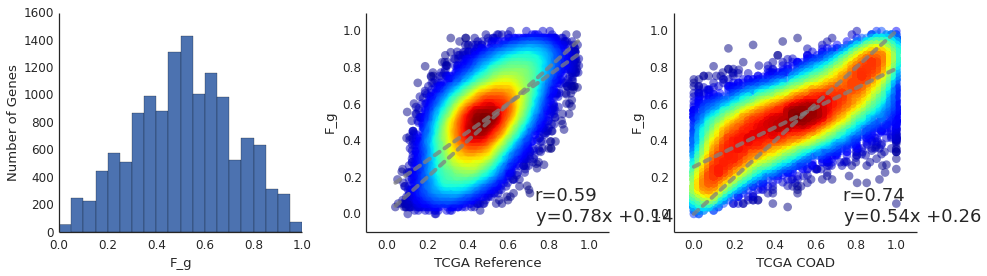

In [130]:
data_summary(d2, 'COAD')

#### Polyp vs. normal

12017 matching genes in dataset.


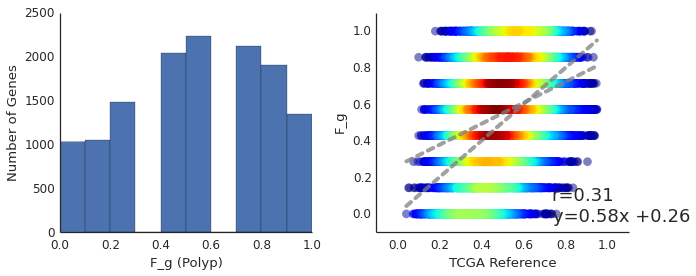

In [131]:
dx = (d2.xs('Polyp',1,1) - d2.xs('11',1,1)).dropna(1) > 0
frac = dx.dropna(1).mean(1)
    
fig, axs = subplots(1,2, figsize=(9,4))
frac.hist(bins=10, ax=axs[0])
axs[0].set_ylabel('Number of Genes')
axs[0].set_xlabel("F_g (Polyp)")
prettify_ax(axs[0])

s1, s2 = match_series(REFERENCE_FRAC, frac)
print '{} matching genes in dataset.'.format(len(s1))
plot_regression(s1, s2, density=True, rad=.1, ax=axs[1])
axs[1].set_ylabel('F_g')
fig.tight_layout()

#### Metastasis vs. normal

12017 matching genes in dataset.


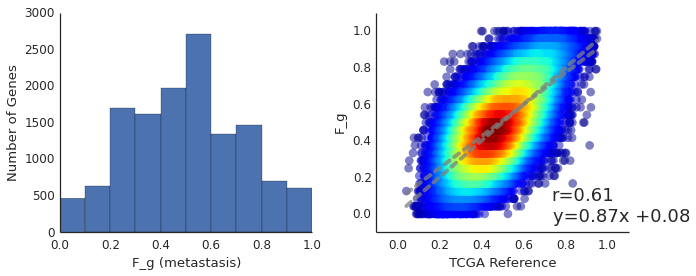

In [132]:
dx = (d2.xs('06',1,1) - d2.xs('11',1,1)).dropna(1) > 0
frac = dx.dropna(1).mean(1)
    
fig, axs = subplots(1,2, figsize=(9,4))
frac.hist(bins=10, ax=axs[0])
axs[0].set_ylabel('Number of Genes')
axs[0].set_xlabel("F_g (metastasis)")
prettify_ax(axs[0])

s1, s2 = match_series(REFERENCE_FRAC, frac)
print '{} matching genes in dataset.'.format(len(s1))
plot_regression(s1, s2, density=True, rad=.1, ax=axs[1])
axs[1].set_ylabel('F_g')
fig.tight_layout()

In [133]:
DATA[('COADREAD','GSE41258')] = d2

In [134]:
df = pd.concat(DATA, 1)
cols = [('_'.join([c[1], c[2]]), c[3]) for c in df.columns]
cols = pd.MultiIndex.from_tuples(cols)
tissue = pd.Series({('_'.join([c[1], c[2]]), c[3]): c[0] for c in df.columns})
df.columns = cols
df = df.groupby(axis=1, level=[0,1]).mean()
df = df.ix[df.index.intersection(rna_df.index)]
df = df.astype(float)

In [136]:
if False:
    store = pd.HDFStore('/data_ssd/GEO_microarray_dx.h5')
    store['tissue'] = tissue
    df.to_hdf(store, 'data')
    store.close()